In [1]:
import collections.abc
collections.Iterable = collections.abc.Iterable
collections.Mapping = collections.abc.Mapping
collections.MutableSet = collections.abc.MutableSet
collections.MutableMapping = collections.abc.MutableMapping

import matplotlib as mpl
import matplotlib.animation
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib ipympl
import h5py 

plt.rcParams['figure.figsize'] = [10, 4]
plt.rcParams['font.size'] = 8
mpl.rc('image', cmap='gray')
import trackpy as tp
tp.quiet()

import joblib 

import numpy as np
import pandas as pd
import csv, json
import pims
from PIL import Image, ImageDraw
import cv2

from scipy.optimize import dual_annealing, linear_sum_assignment
from scipy.spatial import distance_matrix
from tqdm import tqdm
import random

import skimage
from csbdeep.utils import normalize
from stardist.models import StarDist2D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
from stardist import random_label_cmap, _draw_polygons, export_imagej_rois

np.random.seed(6)
lbl_cmap = random_label_cmap()
# initialize model with versatile fluorescence pretrained weights
model = StarDist2D.from_pretrained('2D_versatile_fluo')
print(model)

run_preprocessing_verb = False
def get_data_preload(startFrame, endFrame, data_preload_path, dataset_name):
    with h5py.File(data_preload_path, 'r') as f:
        dataset = f[dataset_name]
        frameImg = dataset[startFrame:endFrame]
    return frameImg


@pims.pipeline
def preprocessing(image, w, h, x1, y1, x2, y2):
    """
    Preprocessing function for the data.

    Parameters
    ----------
    image : pims.Frame
        Frame of the video.
    x1 : int
        x coordinate of the top left corner of the ROI. (region of interest)
    y1 : int
        y coordinate of the top left corner of the ROI.
    x2 : int    
        x coordinate of the bottom right corner of the ROI.
    y2 : int    
        y coordinate of the bottom right corner of the ROI.

    Returns
    -------
    npImage : np.array
        Preprocessed image.
    """
    npImage = np.array(image)
    alpha = Image.new('L', (h, w), 0)
    draw = ImageDraw.Draw(alpha)
    draw.pieslice(((x1, y1), (x2, y2)), 0, 360, fill=255)
    npAlpha = np.array(alpha)
    npImage = cv2.cvtColor(npImage, cv2.COLOR_BGR2GRAY)*npAlpha
    ind = np.where(npImage == 0)
    npImage[ind] = npImage[200, 200]
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    # sharpen image https://en.wikipedia.org/wiki/Kernel_(image_processing)
    image_sharp = cv2.filter2D(src=npImage, ddepth=-1, kernel=kernel)
    return npImage

2023-08-02 22:50:46.478765: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found model '2D_versatile_fluo' for 'StarDist2D'.


2023-08-02 22:50:58.741721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
StarDist2D(2D_versatile_fluo): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 1], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[256, 256], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.2], train_class_weights=(1

In [2]:
video_selection = "25b25r"
#video_selection = "49b1r"

if video_selection == "49b1r":
    print("Import data 49b_1r ...")
    system_name = "49b-1r system"
    source_path = './data/49b1r.mp4'
    path = './49b_1r/'
    part = 1
    data_preload_path = f'/Volumes/ExtremeSSD/UNI/h5_data_thesis/49b-1r/part{part}.h5'

    ref = pims.open(source_path)
    h = 920
    w = 960
    xmin = 55
    ymin = 55
    xmax = 880
    ymax = 880
    data  = preprocessing(ref, h, w, xmin, ymin, xmax, ymax) 
    frames = np.arange(0, 30000, 1)
    fps = 10
    nDrops = 50

elif video_selection == "25b25r":
    print("Import data 25b_25r ...")
    system_name = "25b-25r system"
    source_path = './data/25b25r-1.mp4'
    part = 2
    path = f'./25b_25r/part{part}/'
    data_preload_path = f'/Volumes/ExtremeSSD/UNI/h5_data_thesis/25b-25r/part{part}.h5'
    ref = pims.open(source_path)
    if part == 1:
        rmax = 12
        rmin = 8.3
        frames = np.arange(0, 10**5, 1, dtype=int)
    if part == 2:
        rmax = 11
        rmin = 7
        frames = np.arange(10**5, 2*10**5, 1, dtype=int)
    h = 480
    w = 640
    xmin = 100
    ymin = 35 
    xmax = 530
    ymax = 465
    data  = preprocessing(ref, h, w, xmin, ymin, xmax, ymax) 
    
    fps = 30
    nDrops = 50
else:
    raise ValueError("No valid video selection")

Import data 25b_25r ...


In [3]:
from skimage import io
import numpy as np
masks_path = '/Volumes/ExtremeSSD/data/masks/'
images_path = '/Volumes/ExtremeSSD/data/images/'

In [14]:
np.random.seed(0)
test_samples = np.random.choice(frames, 100) 
droplets_found = []
segm = np.zeros((len(test_samples), h, w), dtype=np.uint8)

i = 0
for frame in tqdm(test_samples):
    img = get_data_preload(frame - frames[0], frame - frames[0] + 1, data_preload_path, 'dataset_name').reshape(h, w)
    io.imsave(images_path + f'image_{i}.tiff', img, plugin='tifffile')
    """ temp, dict_test = model.predict_instances(normalize(img), predict_kwargs = {'verbose':False}) 
    temp[temp>0] = 1
    segm[i] = temp
    io.imsave(masks_path + f'mask_{i}.tiff', temp.astype(np.bool_), plugin='tifffile')
    droplets_found.append(dict_test['coord'].shape[0])
    """
    i += 1

100%|██████████| 100/100 [00:53<00:00,  1.86it/s]


In [8]:
img.dtype

dtype('uint8')

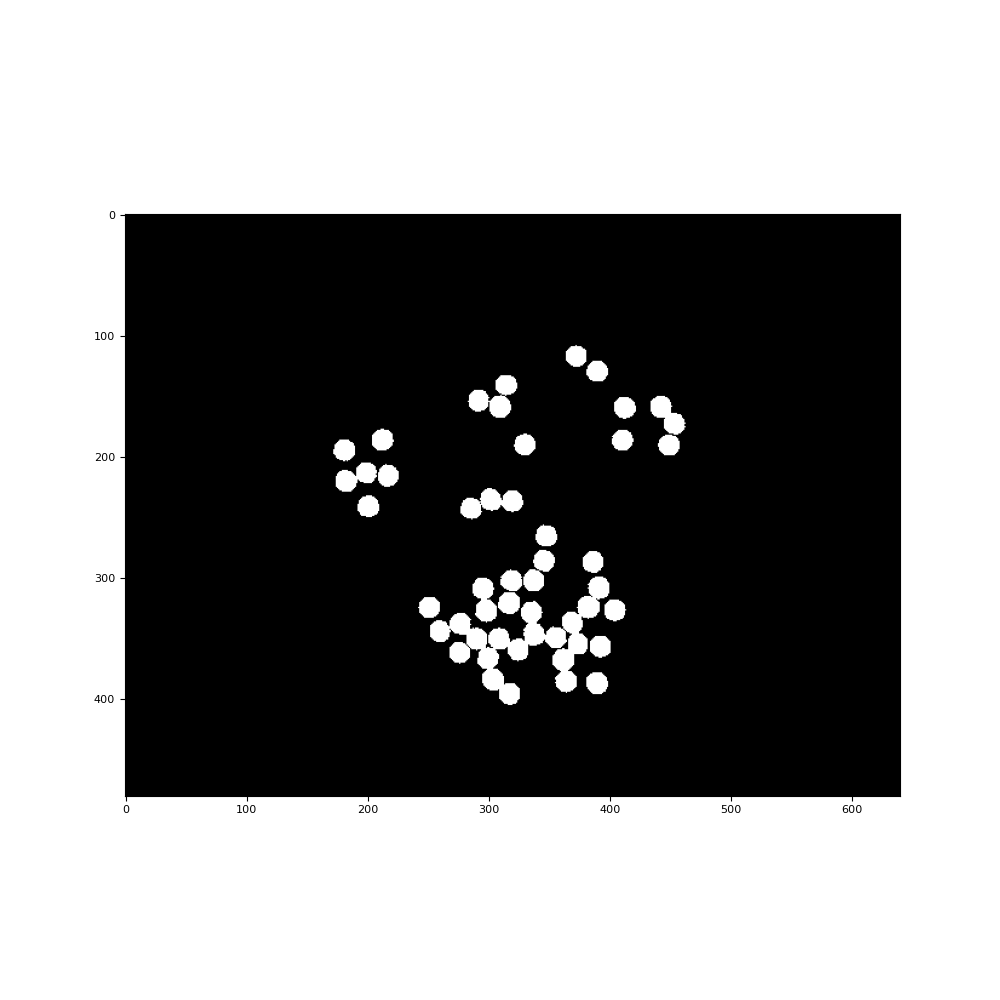

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(temp.astype(np.uint8))
plt.show()

In [39]:
i = 0
for frame in tqdm(test_samples):
    img = get_data_preload(frame - frames[0], frame - frames[0] + 1, data_preload_path, 'dataset_name').reshape(h, w)
    io.imsave(images_path + f'image_{i}', img, plugin='tifffile')
    io.imsave(masks_path + f'mask_{i}', segm[i], plugin='tifffile')
    i += 1

  9%|▉         | 9/100 [00:06<01:07,  1.36it/s]


KeyboardInterrupt: 